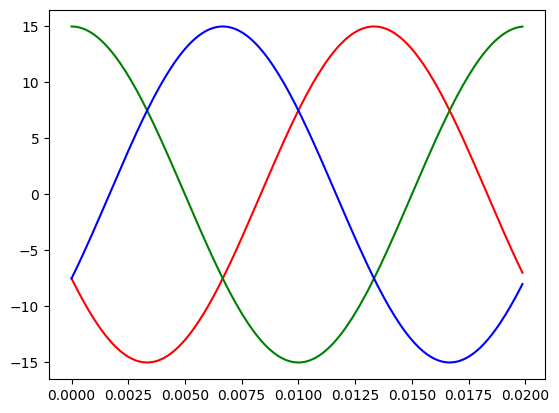

In [3]:
import nest_asyncio
nest_asyncio.apply()
import umbridge
import numpy as np
import matplotlib.pyplot as plt

#model = umbridge.HTTPModel("http://localhost:4242","MODEL_NAME")

#Define time interval
t = np.arange(0,20e-3,125e-6) 

omega_AC = 2*np.pi*50
I_AC = 15

def y_ref(t,k):
    return I_AC*np.cos(omega_AC*t-2*np.pi*(k-1)/3)

data=[]
for k in range (3):
    data.append([y_ref(val,k) for val in t])


fig,ax = plt.subplots()

ax.plot(t,data[0],color="red",label="k=1")
ax.plot(t,data[1],color="green",label="k=2")
ax.plot(t,data[2],color="blue",label="k=3")
plt.show()


In [1]:
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad


# A matrix
def a(n,R_arm, R_DC, L_arm, L_DC, R_AC, L_AC):
    A = np.zeros((n,n))
    np.fill_diagonal(A, [0, -(R_arm+3*R_DC)/(L_arm+3*L_DC), -(R_arm)/(L_arm), -(R_arm)/(L_arm), -(R_arm+2*R_AC)/(L_arm+2*L_AC), -(R_arm+2*R_AC)/(L_arm+2*L_AC)])
    return A  

# B matrix
def b(n, L_arm, L_DC, L_AC):
    B = np.zeros((n, n))
    np.fill_diagonal(B, [0, -(1)/(L_arm+3*L_DC), -(1)/(L_arm), -(1)/(L_arm), -(1)/(L_arm+2*L_AC), -(1)/(L_arm+2*L_AC)])
    return B  


# F matrix
def f(n, L_arm, L_DC, L_AC):
    F = np.zeros((n , n -2))
    F[1][3] = (-(np.sqrt(6)))/(2*L_arm+6*L_DC)
    F[4][0] = (1/(L_arm+2*L_AC))
    F[4][1] = (-1/(L_arm+2*L_AC))
    F[5][0] = (np.sqrt(3)/(3*L_arm+6*L_AC))
    F[5][1] = (np.sqrt(3)/(3*L_arm+6*L_AC))
    F[5][2] = (-(np.sqrt(3))/(3*L_arm+6*L_AC))
    return F  

#C matrix
def c(n):
    C = np.zeros((n,n))
    C[0][0] = 2
    C[4][4] = 2
    C[5][5] = 2
    return C

# T matrix 
T = np.array( [[1/np.sqrt(6), 1/np.sqrt(6), 1/np.sqrt(6), 1/np.sqrt(6), 1/np.sqrt(6), 1/np.sqrt(6)],
                      [-1/np.sqrt(6), -1/np.sqrt(6), -1/np.sqrt(6), 1/np.sqrt(6), 1/np.sqrt(6), 1/np.sqrt(6)],
                      [1/2, -1/2, 0, -1/2, 1/2, 0],
                      [1/np.sqrt(12), 1/np.sqrt(12), -1/np.sqrt(3), -1/np.sqrt(12), -1/np.sqrt(12), 1/np.sqrt(3)],
                      [-1/2, 1/2, 0, -1/2, 1/2, 0],
                      [-1/np.sqrt(12), -1/np.sqrt(12), 1/np.sqrt(3), -1/np.sqrt(12), -1/np.sqrt(12), 1/np.sqrt(3)],
                     ])

# Define the input parameters according to the nominal values given in the version 3 of the paper
R_arm = 20e-3   # 20 mΩ, will vary in a 10 percent range
R_DC = 10e-3      # 10 mΩ, fix so it will not vary
R_AC = 60e-3    # 60 mΩ, will vary in a 10 percent range
L_arm = 200e-6  # 200 µH, will vary in a 10 percent range
L_DC = 5e-3      # 5 mH, fix so it will not vary
L_AC = 320e-3   # 320 mH, will vary in a 10 percent range
#u_parameters =  [599.3, 23.3, 427.5, 100.7, 676.7, 272.5]  # Values within the voltage constraint (<= 800V)
omega = 2*np.pi*50  # Example angular frequency (50 Hz)
I_AC = 15
U_AC = 700
U_DC = 325

def control_vector_without_phases(t, p):
    u1 = p[0] + p[1]*np.sin(2*np.pi*p[2]*t) + p[3]*np.cos(2*np.pi*p[4]*t)
    u2 = p[5] + p[6]*np.sin(2*np.pi*p[7]*t) + p[8]*np.cos(2*np.pi*p[9]*t)
    u3 = p[10] + p[11]*np.sin(2*np.pi*p[12]*t) + p[13]*np.cos(2*np.pi*p[14]*t)
    u4 = p[15] + p[16]*np.sin(2*np.pi*p[17]*t) + p[18]*np.cos(2*np.pi*p[19]*t)
    u5 = p[20] + p[21]*np.sin(2*np.pi*p[22]*t) + p[23]*np.cos(2*np.pi*p[24]*t)
    u6 = p[25] + p[26]*np.sin(2*np.pi*p[27]*t) + p[28]*np.cos(2*np.pi*p[29]*t)
        
    return np.array([u1, u2, u3, u4, u5, u6])

def control_vector(t, p):
    u1 = p[0] + p[1]*np.sin(2*np.pi*(p[2]*t + p[3])) + p[4]*np.cos(2*np.pi*(p[5]*t + p[6]))
    u2 = p[7] + p[8]*np.sin(2*np.pi*(p[9]*t + p[10])) + p[11]*np.cos(2*np.pi*(p[12]*t + p[13]))
    u3 = p[14] + p[15]*np.sin(2*np.pi*(p[16]*t + p[17])) + p[18]*np.cos(2*np.pi*(p[19]*t + p[20]))
    u4 = p[21] + p[22]*np.sin(2*np.pi*(p[23]*t + p[24])) + p[25]*np.cos(2*np.pi*(p[26]*t + p[27]))
    u5 = p[28] + p[29]*np.sin(2*np.pi*(p[30]*t + p[31])) + p[32]*np.cos(2*np.pi*(p[33]*t + p[34]))
    u6 = p[35] + p[36]*np.sin(2*np.pi*(p[37]*t + p[38])) + p[39]*np.cos(2*np.pi*(p[40]*t + p[41]))

    return np.array([u1, u2, u3, u4, u5, u6])


def disturbance_vector(t, omega_AC, U_AC, U_DC):
    z = []
    for k in range(3):
        z.append(U_AC * np.cos (omega_AC * t - (2 * np.pi * (k-1))/3))

    z.append(U_DC)
    return np.array(z)

# Define the reference solution for the output currents i_1...i_3, i.e. y_1...y_3
def y_reference(t,I_AC,omega_AC):
    y = []
    for k in range(3):
        y.append(I_AC*np.cos(omega_AC*t)-2*np.pi*(k-1)/3)
    return np.array(y)

def MMC_ODE(t, x_tilde, p, A_tilde, B_tilde, F_tilde, T, omega_AC, U_AC, U_DC):
    u = control_vector(t,p)
    z = disturbance_vector(t,omega_AC,U_AC,U_DC)
    dx_tildedt= A_tilde @ x_tilde + B_tilde @ (T @ u) + F_tilde @ z

    return dx_tildedt

def y_sol(p,x0, A_tilde, B_tilde, F_tilde, T, omega_AC, U_AC, U_DC,t_span=[0,20e-3],t_eval=np.arange(0,20e-3+125e-6,125e-6)):

    #Calculate x_tilde_1-6 -> shape (6,160)
    ode_sol = solve_ivp(MMC_ODE,t_span=t_span,y0=x0,method="RK45",t_eval=t_eval,args=(p,A_tilde,B_tilde,F_tilde,T,omega_AC,U_AC,U_DC))

    #return y vector to compare with y_ref
    x_tilde_sol = ode_sol.y
    y = np.array([-x_tilde_sol[4]-1/np.sqrt(3)*x_tilde_sol[5],x_tilde_sol[4]-1/np.sqrt(3)*x_tilde_sol[5],2/np.sqrt(3)*x_tilde_sol[5]])

    return y






In [2]:
#Define inital values for the parameters of the control vector u
u0 = [599.3, 23.3, 427.5, 100.7, 676.7, 272.5]
p_initial = [599.3/2,0,50,0,599.3/2,50,0,
             23.3/2,0,50,0,23.3/2,50,0,
             427.5/2,0,50,0,427.5/2,50,0,
             100.7/2,0,50,0,100.7/2,50,0,
             676.7/2,0,50,0,676.7/2,50,0,
             272.5/2,0,50,0,272.5/2,50,0]

#Define inital values for x_tilde
x_tilde0 = [0,0,0,0,0,0]

#Define matrices
A = a(n=6,R_arm=R_arm,R_DC=R_DC,L_arm=L_arm,L_DC=L_DC,R_AC=R_AC,L_AC=L_AC)
B = b(n=6,L_arm=L_arm,L_DC=L_DC,L_AC=L_AC)
F = f(n=6,L_arm=L_arm,L_DC=L_DC,L_AC=L_AC)
C = c(n=6)

#Define time interval in which the ODE is to be solved and the time steps at which it is to be evaluated
t_start,t_stop,t_step = 0,20e-3,125e-6
t_eval = np.arange(t_start,t_stop+t_step,t_step)
t_span = [t_eval[0],t_eval[-1]]

#Solve the ODE for these parameters
y_sol_test = y_sol(p=p_initial,x0=x_tilde0,A_tilde=A,B_tilde=B,F_tilde=F,T=T,omega_AC=omega,U_AC=U_AC,U_DC=U_DC,t_span=t_span,t_eval=t_eval)

In [3]:
#Do optimisation procedure to find optimal parameters p[0]...p[29] to match y from y_sol with y_ref
def objective_function(p, x0, A_tilde, B_tilde, F_tilde, T, omega_AC, U_AC, U_DC,t_span,t_eval,y_ref):
    """
    Calculate the MSE between the actual output of the MMC and the desired y_ref
    """
    y_out = y_sol(p, x0, A_tilde, B_tilde, F_tilde, T, omega_AC, U_AC, U_DC,t_span,t_eval)

    #Calculate mse. Cautious: the shape returned by y_sol is (160,3), i.e. not the normal way of defining vectors. Thus, transpose it to compare it to y_ref
    mse = np.mean((y_out.T-y_ref)**2)
    return mse

#Define reference vector 
y_ref = np.array([y_reference(t,I_AC=I_AC,omega_AC=omega) for t in t_eval])


#Implement constraints 
def arm_powers(x_tilde,T,p,t_eval):
    """
    Calculate the arm powers for the numerically determined x_tilde_1..x_tilde_6 at the same t_eval points
    """
    u = control_vector(t,p)
    u_t = np.array([u(t,p) for t in t_eval])
    x_tilde_power = np.multiply(T.T @ (T @ u_t), T.T @ x_tilde) 
    return x_tilde_power


def constraint_arm_power(p,x0,A_tilde,B_tilde,F_tilde,omega_AC,U_AC,U_DC,upper_bound,t_span,t_eval):
    """
    Define constraint on arm powers, i.e. derivatives of x_7...x_12. That is, they must not exceed 5 kW
    """
    #Solve ode
    sol = solve_ivp(MMC_ODE,t_span,x0,method="RK45",t_eval,args=(p,A_tilde,B_tilde,F_tilde,T,omega_AC,U_AC,U_DC))
    x_tilde_sol = sol.y

    #Calculate arm powers
    x_tilde_power = arm_powers(x_tilde_sol,T,p,t_eval)

    #Enforce that x_tilde_power is within the specified bounds
    return upper_bound-x_tilde_power

def constraint_control_vector(p, t_eval,upper_bound):
    """
    Ensure that the absolute value of each control vector entry is less than or equal to 800
    for each time step in t_eval.
    """
    for t in t_eval:
        u = control_vector(t, p)  # Compute u(t) at time t
        
        # Check that |u_i(t)| <= 800 for each u_i
        if np.any(np.abs(u) > upper_bound):
            return -1  # Return negative if any entry exceeds 800
    
    return 0  # Return 0 if the constraint is satisfied

#Define upper bounds for constraints
arm_powers_upper_bound = 5e3 #in W
control_vector_upper_bound = 800 #in V

#Define constraints
constraint = {"type": "ineq","fun":constraint_arm_power, "args":(x_tilde0,A,B,F,omega,U_AC,U_DC,arm_powers_upper_bound,t_span,t_eval),
              "type": "ineq","fun":constraint_control_vector,"args":(t_eval,control_vector_upper_bound)}
# Perform optimization to minimize the objective function
p_result = minimize(objective_function, x0=p_initial, args=(x_tilde0, A, B, F, T, omega, U_AC, U_DC,t_span,t_eval, y_ref), method='L-BFGS-B')

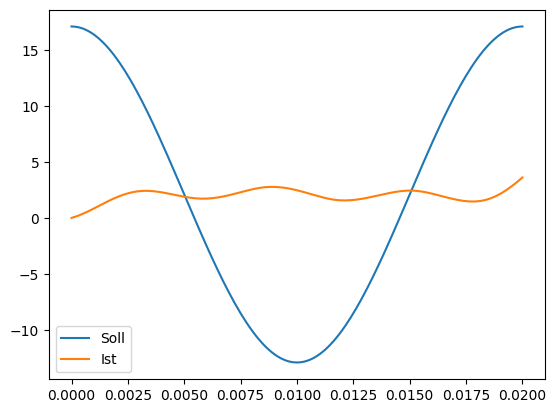

In [5]:
#save optimised parameters
p_optimised = p_result.x

#Compare y calculated with control vector with optimised parameters to y_ref
y_sol_optimised_p = y_sol(p=p_optimised,x0=x_tilde0,A_tilde=A,B_tilde=B,F_tilde=F,T=T,omega_AC=omega,U_AC=U_AC,U_DC=U_DC)

#Plot solution
plt.plot(t_eval,[y_reference(t,I_AC=I_AC,omega_AC=omega)[0] for t in t_eval],label="Soll")
plt.plot(t_eval,y_sol_optimised_p[0],label="Ist")
plt.legend()

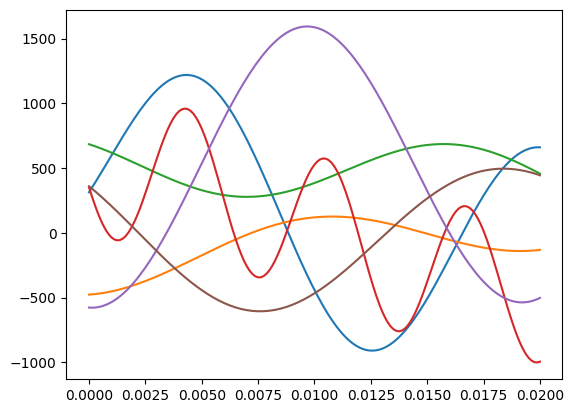

In [6]:
plt.plot(t_eval,[control_vector(t,p_optimised) for t in t_eval])